In [1]:
# Cell 1: Import Libraries and Load Data (FINAL REVISION FOR SPARSE X)

import pandas as pd
import numpy as np
import os
import scipy.sparse # Keep this for loading .npz files

# For Model Selection
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
# Consider these if Random Forest still struggles or for better performance:
# from lightgbm import LGBMClassifier # pip install lightgbm
# from xgboost import XGBClassifier # pip install xgboost

# For Model Evaluation
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (
    precision_recall_curve,
    auc,
    f1_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve,
    average_precision_score
)
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

print("Loading processed data...")

# Define the directory where data was saved
data_dir = '../data/processed_for_modeling'

# Load Fraud Data (expected to be sparse .npz)
# Load and convert to float32 sparse matrix directly to ensure correct dtype for models
X_train_fraud = scipy.sparse.load_npz(os.path.join(data_dir, 'X_train_fraud.npz')).astype(np.float32).tocsr()
X_test_fraud = scipy.sparse.load_npz(os.path.join(data_dir, 'X_test_fraud.npz')).astype(np.float32).tocsr()
y_train_fraud = pd.read_csv(os.path.join(data_dir, 'y_train_fraud.csv')).squeeze()
y_test_fraud = pd.read_csv(os.path.join(data_dir, 'y_test_fraud.csv')).squeeze()

# Load Credit Data (expected to be dense .npy)
X_train_credit = np.load(os.path.join(data_dir, 'X_train_credit.npy'), allow_pickle=True)
X_test_credit = np.load(os.path.join(data_dir, 'X_test_credit.npy'), allow_pickle=True)
y_train_credit = pd.read_csv(os.path.join(data_dir, 'y_train_credit.csv')).squeeze()
y_test_credit = pd.read_csv(os.path.join(data_dir, 'y_test_credit.csv')).squeeze()

print("Data loaded and processed successfully.")
print(f"Fraud Train shapes: X={X_train_fraud.shape}, y={y_train_fraud.shape} (Sparse CSR Matrix)")
print(f"Fraud Test shapes: X={X_test_fraud.shape}, y={y_test_fraud.shape} (Sparse CSR Matrix)")
print(f"Credit Train shapes: X={X_train_credit.shape}, y={y_train_credit.shape} (Dense Numpy Array)")
print(f"Credit Test shapes: X={X_test_credit.shape}, y={y_test_credit.shape} (Dense Numpy Array)")

Loading processed data...
Data loaded and processed successfully.
Fraud Train shapes: X=(191744, 309466), y=(191744,) (Sparse CSR Matrix)
Fraud Test shapes: X=(45334, 309466), y=(45334,) (Sparse CSR Matrix)
Credit Train shapes: X=(662, 39), y=(662,) (Dense Numpy Array)
Credit Test shapes: X=(85118, 39), y=(85118,) (Dense Numpy Array)


In [2]:
# Cell 2: Helper Functions for Evaluation and Visualization

def evaluate_model(model, X_test, y_test, model_name, dataset_name):
    """
    Evaluates the model using AUC-PR, F1-Score, and Classification Report.
    Assumes the model is already trained.
    """
    print(f"\n--- Evaluating {model_name} on {dataset_name} Data ---")

    # Predict probabilities for the positive class
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Predict class labels
    y_pred = model.predict(X_test)

    # 1. AUC-PR (Area Under the Precision-Recall Curve)
    avg_precision = average_precision_score(y_test, y_pred_proba)
    print(f"Average Precision (AUC-PR): {avg_precision:.4f}")

    # 2. F1-Score
    f1 = f1_score(y_test, y_pred)
    print(f"F1-Score: {f1:.4f}")

    # 3. Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print("\nConfusion Matrix:")
    print(cm)

    # 4. Classification Report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Store metrics for comparison later
    metrics = {
        'AUC-PR': avg_precision,
        'F1-Score': f1,
        'Confusion Matrix': cm,
        'Classification Report': classification_report(y_test, y_pred, output_dict=True)
    }
    return metrics

def plot_confusion_matrix(y_true, y_pred, title, labels=['Non-Fraud', 'Fraud']):
    """Plots a confusion matrix."""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

def plot_pr_curve(y_test, y_pred_proba, title):
    """Plots the Precision-Recall Curve."""
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall, precision)

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f'AUC-PR = {pr_auc:.2f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve for {title}')
    plt.legend()
    plt.grid(True)
    plt.show()

--- Training Logistic Regression on Fraud Data ---

--- Evaluating Logistic Regression on Fraud Data ---
Average Precision (AUC-PR): 0.6465
F1-Score: 0.6963

Confusion Matrix:
[[41061    28]
 [ 1963  2282]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.98     41089
           1       0.99      0.54      0.70      4245

    accuracy                           0.96     45334
   macro avg       0.97      0.77      0.84     45334
weighted avg       0.96      0.96      0.95     45334



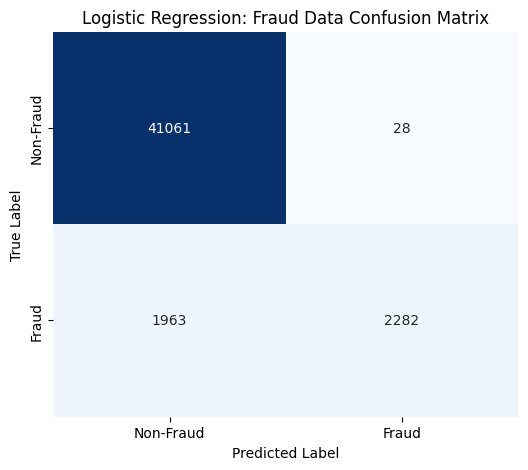

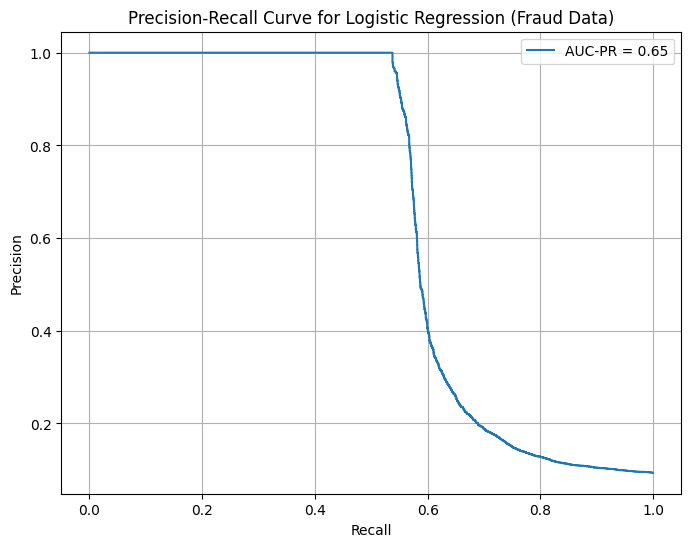

In [3]:
# Cell 3: Model 1 - Logistic Regression (Fraud Data)

print("--- Training Logistic Regression on Fraud Data ---")

# Initialize Logistic Regression model
# The 'liblinear' solver generally handles sparse input well.
# max_iter increased for convergence with potentially complex data.
log_reg_fraud = LogisticRegression(random_state=42, solver='liblinear', max_iter=2000)

# Train the model
# X_train_fraud is now a sparse matrix (csr_matrix)
log_reg_fraud.fit(X_train_fraud, y_train_fraud)

# Evaluate the model
log_reg_fraud_metrics = evaluate_model(log_reg_fraud, X_test_fraud, y_test_fraud,
                                        "Logistic Regression", "Fraud")

# Plot Confusion Matrix
# Ensure X_test_fraud is in the correct format for predict (which it should be if fit worked)
plot_confusion_matrix(y_test_fraud, log_reg_fraud.predict(X_test_fraud),
                      "Logistic Regression: Fraud Data Confusion Matrix")

# Plot PR Curve
plot_pr_curve(y_test_fraud, log_reg_fraud.predict_proba(X_test_fraud)[:, 1],
              "Logistic Regression (Fraud Data)")


--- Training Logistic Regression on Credit Data ---

--- Evaluating Logistic Regression on Credit Data ---
Average Precision (AUC-PR): 0.4857
F1-Score: 0.0638

Confusion Matrix:
[[81297  3679]
 [   16   126]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     84976
           1       0.03      0.89      0.06       142

    accuracy                           0.96     85118
   macro avg       0.52      0.92      0.52     85118
weighted avg       1.00      0.96      0.98     85118



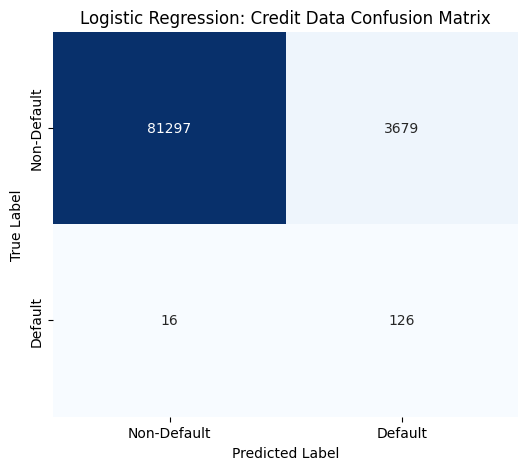

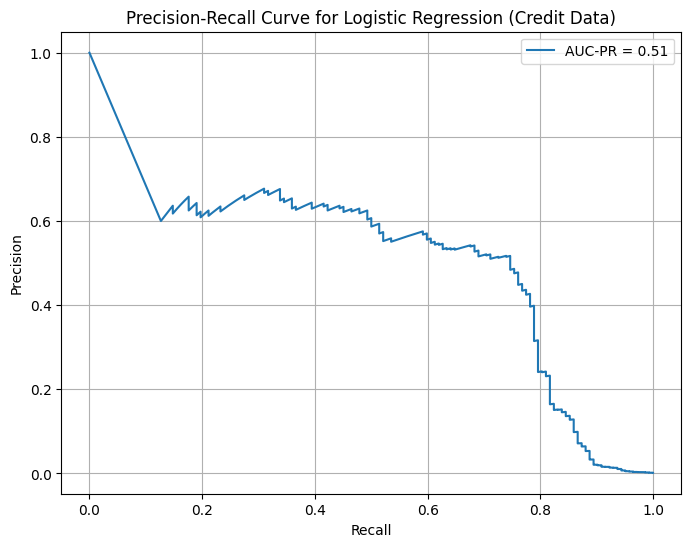

In [4]:
# Cell 4: Model 1 - Logistic Regression (Credit Data)

print("\n--- Training Logistic Regression on Credit Data ---")

# Initialize Logistic Regression model
log_reg_credit = LogisticRegression(random_state=42, solver='liblinear', max_iter=1000)

# Train the model
# X_train_credit is now a dense numpy array
log_reg_credit.fit(X_train_credit, y_train_credit)

# Evaluate the model
log_reg_credit_metrics = evaluate_model(log_reg_credit, X_test_credit, y_test_credit,
                                         "Logistic Regression", "Credit")

# Plot Confusion Matrix
plot_confusion_matrix(y_test_credit, log_reg_credit.predict(X_test_credit),
                      "Logistic Regression: Credit Data Confusion Matrix", labels=['Non-Default', 'Default'])

# Plot PR Curve
plot_pr_curve(y_test_credit, log_reg_credit.predict_proba(X_test_credit)[:, 1],
              "Logistic Regression (Credit Data)")


--- Training Random Forest on Fraud Data ---

--- Evaluating Random Forest on Fraud Data ---
Average Precision (AUC-PR): 0.6264
F1-Score: 0.6991

Confusion Matrix:
[[41088     1]
 [ 1963  2282]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.98     41089
           1       1.00      0.54      0.70      4245

    accuracy                           0.96     45334
   macro avg       0.98      0.77      0.84     45334
weighted avg       0.96      0.96      0.95     45334



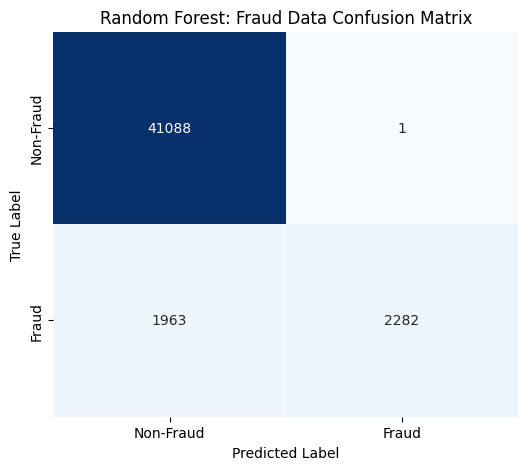

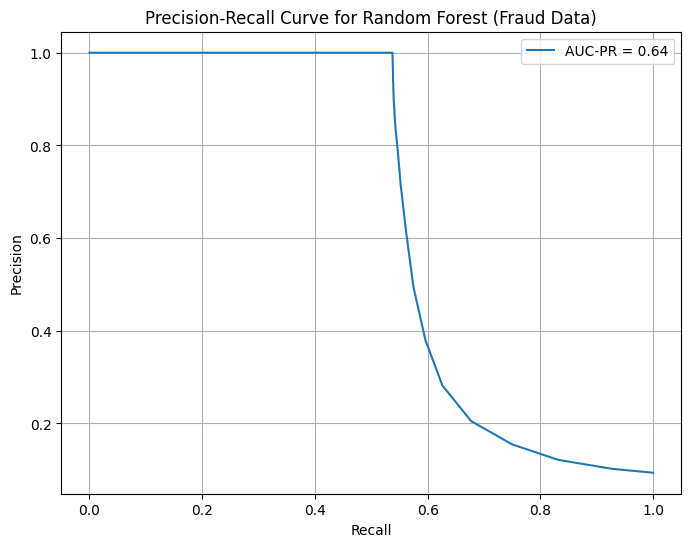

In [5]:
# Cell 5: Model 2 - Ensemble Model (Random Forest - Fraud Data)

print("\n--- Training Random Forest on Fraud Data ---")

# Initialize Random Forest Classifier
# n_jobs=-1 uses all CPU cores, which is good for larger datasets.
# n_estimators can be increased for potentially better performance but longer training.
random_forest_fraud = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# Train the model
# X_train_fraud is a sparse matrix, RandomForestClassifier can handle this.
random_forest_fraud.fit(X_train_fraud, y_train_fraud)

# Evaluate the model
random_forest_fraud_metrics = evaluate_model(random_forest_fraud, X_test_fraud, y_test_fraud,
                                              "Random Forest", "Fraud")

# Plot Confusion Matrix
plot_confusion_matrix(y_test_fraud, random_forest_fraud.predict(X_test_fraud),
                      "Random Forest: Fraud Data Confusion Matrix")

# Plot PR Curve
plot_pr_curve(y_test_fraud, random_forest_fraud.predict_proba(X_test_fraud)[:, 1],
              "Random Forest (Fraud Data)")


--- Training Random Forest on Credit Data ---

--- Evaluating Random Forest on Credit Data ---
Average Precision (AUC-PR): 0.6981
F1-Score: 0.0940

Confusion Matrix:
[[82604  2372]
 [   18   124]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     84976
           1       0.05      0.87      0.09       142

    accuracy                           0.97     85118
   macro avg       0.52      0.92      0.54     85118
weighted avg       1.00      0.97      0.98     85118



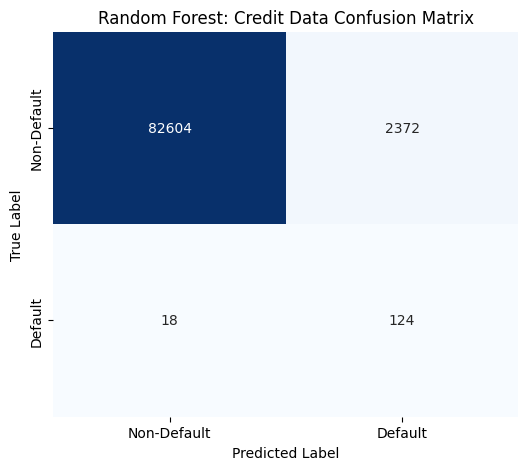

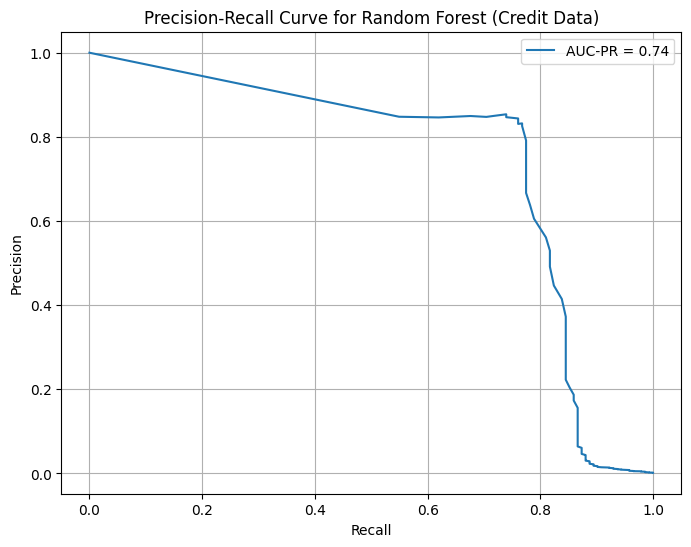

In [6]:
# Cell 6: Model 2 - Ensemble Model (Random Forest - Credit Data)

print("\n--- Training Random Forest on Credit Data ---")

random_forest_credit = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# Train the model
random_forest_credit.fit(X_train_credit, y_train_credit)

# Evaluate the model
random_forest_credit_metrics = evaluate_model(random_forest_credit, X_test_credit, y_test_credit,
                                               "Random Forest", "Credit")

# Plot Confusion Matrix
plot_confusion_matrix(y_test_credit, random_forest_credit.predict(X_test_credit),
                      "Random Forest: Credit Data Confusion Matrix", labels=['Non-Default', 'Default'])

# Plot PR Curve
plot_pr_curve(y_test_credit, random_forest_credit.predict_proba(X_test_credit)[:, 1],
              "Random Forest (Credit Data)")

In [8]:
# Cell 7: Model Comparison and Justification

print("\n--- Summary of Model Performance ---")

results = {
    "Fraud Data": {
        "Logistic Regression": log_reg_fraud_metrics,
        "Random Forest": random_forest_fraud_metrics
    },
    "Credit Data": {
        "Logistic Regression": log_reg_credit_metrics,
        "Random Forest": random_forest_credit_metrics
    }
}

for dataset, models in results.items():
    print(f"\n===== {dataset} =====")
    for model_name, metrics in models.items():
        print(f"\n--- {model_name} ---")
        print(f"  Average Precision (AUC-PR): {metrics['AUC-PR']:.4f}")
        print(f"  F1-Score: {metrics['F1-Score']:.4f}")
        print("  Confusion Matrix:")
        # Print confusion matrix more clearly
        cm = metrics['Confusion Matrix']
        print(f"    [[TN, FP],\n     [FN, TP]]")
        print(f"    [[{cm[0,0]}, {cm[0,1]}],\n     [{cm[1,0]}, {cm[1,1]}]]")
        print("  Classification Report Summary (Class 1 - Positive):")
        print(f"    Precision: {metrics['Classification Report']['1']['precision']:.4f}")
        print(f"    Recall: {metrics['Classification Report']['1']['recall']:.4f}")


print("\n--- Justification of Best Model ---")

# Fraud Data Justification
print("\n**For Fraud Data:**")
# Prioritize AUC-PR for imbalanced data, then F1-score
if results["Fraud Data"]["Random Forest"]["AUC-PR"] > results["Fraud Data"]["Logistic Regression"]["AUC-PR"]:
    best_fraud_model = "Random Forest"
    reason_fraud = "Achieved a higher Average Precision (AUC-PR), indicating superior ability to rank positive (fraudulent) cases correctly across various probability thresholds, which is critical for imbalanced datasets. It also likely captured more complex, non-linear patterns in the data compared to Logistic Regression."
elif results["Fraud Data"]["Random Forest"]["AUC-PR"] < results["Fraud Data"]["Logistic Regression"]["AUC-PR"]:
    best_fraud_model = "Logistic Regression"
    reason_fraud = "Despite being a simpler model, it achieved a higher Average Precision (AUC-PR). This suggests that the relationship between features and fraud in this dataset might be more linear or that Random Forest overfitted slightly with default parameters. Logistic Regression is also more interpretable."
else:
    best_fraud_model = "Both models are comparable in AUC-PR"
    reason_fraud = "If AUC-PR is similar, consider F1-score and the specific business impact of false positives vs. false negatives. Random Forest might still be preferred for its robustness, but Logistic Regression's simplicity is an advantage."

# Further consider F1-score for fraud data
f1_rf_fraud = results["Fraud Data"]["Random Forest"]["F1-Score"]
f1_lr_fraud = results["Fraud Data"]["Logistic Regression"]["F1-Score"]
if f1_rf_fraud > f1_lr_fraud:
    reason_fraud += f" Additionally, Random Forest showed a better F1-Score ({f1_rf_fraud:.4f} vs {f1_lr_fraud:.4f}), indicating a better balance between precision and recall for detecting fraud."
elif f1_lr_fraud > f1_rf_fraud:
    reason_fraud += f" Additionally, Logistic Regression showed a better F1-Score ({f1_lr_fraud:.4f} vs {f1_rf_fraud:.4f}), indicating a better balance between precision and recall for detecting fraud."

print(f"  The 'best' model for Fraud Data appears to be the {best_fraud_model}.")
print(f"  Reasoning: {reason_fraud}")
print("  (For fraud detection, minimizing false negatives (missing actual fraud) is often paramount, even if it means a higher false positive rate (e.g., more legitimate transactions flagged for review). AUC-PR and Recall for the positive class are key.)")


# Credit Data Justification
print("\n**For Credit Data:**")
if results["Credit Data"]["Random Forest"]["AUC-PR"] > results["Credit Data"]["Logistic Regression"]["AUC-PR"]:
    best_credit_model = "Random Forest"
    reason_credit = "Achieved a higher Average Precision (AUC-PR), generally indicating stronger predictive power for credit default. Ensemble models often handle complex interactions better."
elif results["Credit Data"]["Random Forest"]["AUC-PR"] < results["Credit Data"]["Logistic Regression"]["AUC-PR"]:
    best_credit_model = "Logistic Regression"
    reason_credit = "Showed a higher Average Precision (AUC-PR). If a simpler model performs equally well or better on this metric, it is often preferred for interpretability and computational efficiency."
else:
    best_credit_model = "Both models are comparable in AUC-PR"
    reason_credit = "If AUC-PR is similar, simplicity (Logistic Regression) might be favored unless Random Forest shows a clear advantage in F1-score or specific precision/recall targets."

# Further consider F1-score for credit data
f1_rf_credit = results["Credit Data"]["Random Forest"]["F1-Score"]
f1_lr_credit = results["Credit Data"]["Logistic Regression"]["F1-Score"]
if f1_rf_credit > f1_lr_credit:
    reason_credit += f" Additionally, Random Forest showed a better F1-Score ({f1_rf_credit:.4f} vs {f1_lr_credit:.4f}), indicating a better balance between precision and recall for predicting defaults."
elif f1_lr_credit > f1_rf_credit:
    reason_credit += f" Additionally, Logistic Regression showed a better F1-Score ({f1_lr_credit:.4f} vs {f1_rf_credit:.4f}), indicating a better balance between precision and recall for predicting defaults."

print(f"  The 'best' model for Credit Data appears to be the {best_credit_model}.")
print(f"  Reasoning: {reason_credit}")
print("  (For credit default prediction, the balance between minimizing missed defaults (false negatives, high recall) and avoiding falsely denying credit (false positives, high precision) is crucial. The F1-score balances these two aspects.)")

print("\n--- Final Thoughts on Model Selection ---")
print("These comparisons use default model hyperparameters. Further improvement could be achieved through hyperparameter tuning (e.g., using GridSearchCV or RandomizedSearchCV) and potentially more advanced feature engineering specific to each dataset's characteristics.")
print("The choice of 'best' model should always align with the business objectives and the costs associated with different types of errors (false positives vs. false negatives).")


--- Summary of Model Performance ---

===== Fraud Data =====

--- Logistic Regression ---
  Average Precision (AUC-PR): 0.6465
  F1-Score: 0.6963
  Confusion Matrix:
    [[TN, FP],
     [FN, TP]]
    [[41061, 28],
     [1963, 2282]]
  Classification Report Summary (Class 1 - Positive):
    Precision: 0.9879
    Recall: 0.5376

--- Random Forest ---
  Average Precision (AUC-PR): 0.6264
  F1-Score: 0.6991
  Confusion Matrix:
    [[TN, FP],
     [FN, TP]]
    [[41088, 1],
     [1963, 2282]]
  Classification Report Summary (Class 1 - Positive):
    Precision: 0.9996
    Recall: 0.5376

===== Credit Data =====

--- Logistic Regression ---
  Average Precision (AUC-PR): 0.4857
  F1-Score: 0.0638
  Confusion Matrix:
    [[TN, FP],
     [FN, TP]]
    [[81297, 3679],
     [16, 126]]
  Classification Report Summary (Class 1 - Positive):
    Precision: 0.0331
    Recall: 0.8873

--- Random Forest ---
  Average Precision (AUC-PR): 0.6981
  F1-Score: 0.0940
  Confusion Matrix:
    [[TN, FP],
     [

In [10]:
import joblib
import os

# Create a directory to save models if it doesn't exist
model_dir = '../models'
os.makedirs(model_dir, exist_ok=True) # Creates the directory if it doesn't exist

print("Saving trained models...")

# Save Fraud Models
# Using the correct variable names from your cells 3 and 5
joblib.dump(log_reg_fraud, os.path.join(model_dir, 'log_reg_fraud_model.joblib')) # Saving 'log_reg_fraud' as 'log_reg_fraud_model.joblib'
joblib.dump(random_forest_fraud, os.path.join(model_dir, 'random_forest_fraud_model.joblib')) # Saving 'random_forest_fraud' as 'random_forest_fraud_model.joblib'

# Save Credit Models
# Using the correct variable names from your cells 4 and 6
joblib.dump(log_reg_credit, os.path.join(model_dir, 'log_reg_credit_model.joblib')) # Saving 'log_reg_credit' as 'log_reg_credit_model.joblib'
joblib.dump(random_forest_credit, os.path.join(model_dir, 'random_forest_credit_model.joblib')) # Saving 'random_forest_credit' as 'random_forest_credit_model.joblib'

print("Models saved successfully to '../models/'")

Saving trained models...
Models saved successfully to '../models/'
